### 1. Importing Dataset and Libraries

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
import cv2
import librosa
import tensorflow as tf


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16,ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler,OrdinalEncoder,LabelEncoder
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

warnings.filterwarnings('ignore')

# Loading 3-Second Features Dataset
df_3sec_original=pd.read_csv("features_3_sec.csv",encoding='utf-8')
df_3sec=df_3sec_original.copy()
df_3sec.reset_index(drop=True,inplace=True)
print("3-Second Feature Dataset shape is:",df_3sec.shape)

# Loading 30-second features dataset  
df_30sec_original=pd.read_csv("features_30_sec.csv",encoding='utf-8')
df_30sec=df_30sec_original.copy()
df_30sec.reset_index(drop=True,inplace=True)
print("30-Second Dataset shape:",df_30sec.shape)

# only showing first five rows
print("3-Second Features Dataset  (first 5 rows) are:",df_3sec.head())
print("30-Second Features Dataset  (first 5 rows) are:",df_30sec.head())


3-Second Feature Dataset shape is: (9990, 60)
30-Second Dataset shape: (1000, 60)
3-Second Features Dataset  (first 5 rows) are:             filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectra

### 2. Cleaning 3-Second Features Dataset

=== 3-SECOND DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 59 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   chroma_stft_mean         9990 non-null   float64
 2   chroma_stft_var          9990 non-null   float64
 3   rms_mean                 9990 non-null   float64
 4   rms_var                  9990 non-null   float64
 5   spectral_centroid_mean   9990 non-null   float64
 6   spectral_centroid_var    9990 non-null   float64
 7   spectral_bandwidth_mean  9990 non-null   float64
 8   spectral_bandwidth_var   9990 non-null   float64
 9   rolloff_mean             9990 non-null   float64
 10  rolloff_var              9990 non-null   float64
 11  zero_crossing_rate_mean  9990 non-null   float64
 12  zero_crossing_rate_var   9990 non-null   float64
 13  harmony_mean             9990 non-null   float64
 14 

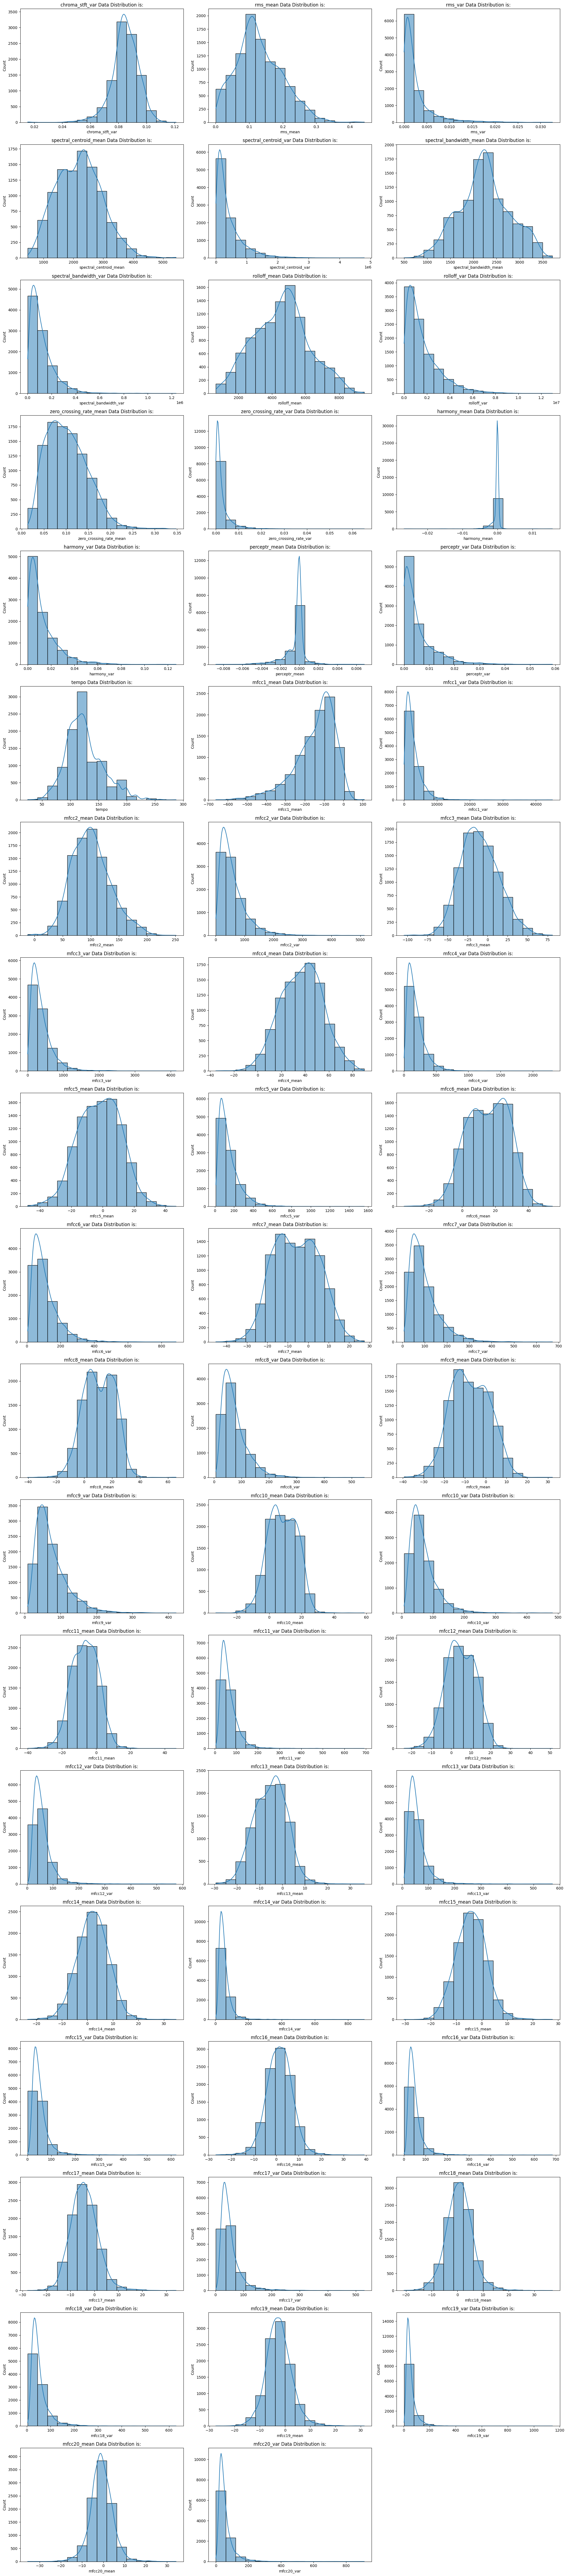


Applied Ordinal Encoding on Categorical columns.


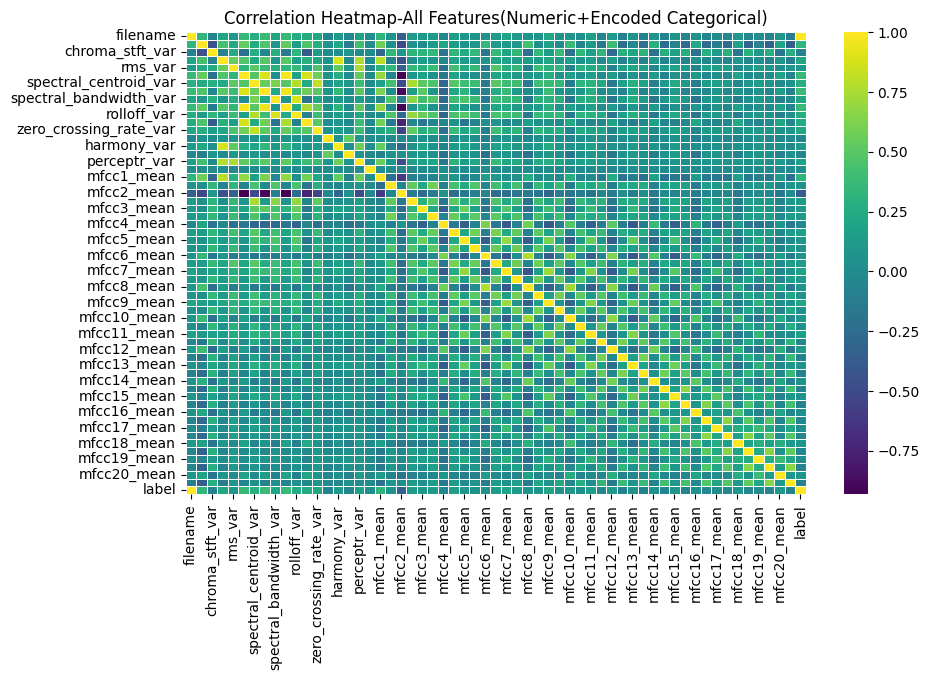

filename  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0       0.0          0.335406         0.091048  0.130405  0.003521   
1       1.0          0.343065         0.086147  0.112699  0.001450   
2       2.0          0.346815         0.092243  0.132003  0.004620   
3       3.0          0.363639         0.086856  0.132565  0.002448   
4       4.0          0.335579         0.088129  0.143289  0.001701   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1773.065032          167541.630869              1972.744388   
1             1816.693777           90525.690866              2010.051501   
2             1788.539719          111407.437613              2084.565132   
3             1655.289045          111952.284517              1960.039988   
4             1630.656199           79667.267654              1948.503884   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_var  mfcc17_mean  \
0           117335.771563   3714.560359  ...   39.687145    -3.241280   
1            65671.875673   3869.682242  ...   64.748276    -6.055294   
2            75124.921716   3997.639160  ...   67.336563    -1.768610   
3            82913.639269   3568.300218  ...   47.739452    -3.841155   
4            60204.020268   3469.992864  ...   30.336359     0.664582   

   mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  mfcc20_mean  \
0   36.488243     0.722209   38.099152    -5.050335   33.618073    -0.243027   
1   40.677654     0.159015   51.264091    -2.837699   97.030830     5.784063   
2   28.348579     2.378768   45.717648    -1.938424   53.050835     2.517375   
3   28.337118     1.218588   34.770935    -3.580352   50.836224     3.630866   
4   45.880913     1.689446   51.363583    -3.392489   26.738789     0.536961   

   mfcc20_var  label  
0   43.771767    0.0  
1   59.943081    0.0  
2   33.105122    0.0  
3   32.023678    0.0  
4   29.146694    0.0  

[5 rows x 59 columns]

In [4]:
# Checking basic info for 3-second dataset
print("=== 3-SECOND DATASET ===")
df_3sec.info()
print("Shape of 3-second dataset is:", df_3sec.shape)
print("Target variable distribution is:")
print(df_3sec['label'].value_counts())

# Separating numeric and categorical columns for 3-second
numeric_columns_3sec=df_3sec.select_dtypes(include=['int64','float64']).columns.tolist()
string_columns_3sec=df_3sec.select_dtypes(include=['object']).columns.tolist()
print("Numeric Columns:",numeric_columns_3sec)
print("Categorical Columns:",string_columns_3sec)

# Checking missing values for 3-second
print("Missing Values per Column in 3-second Dataset:")
print(df_3sec.isnull().sum())

# Checking unique counts of numerical columns
if numeric_columns_3sec:
    print("\nUnique value counts (numerical columns):")
    print(df_3sec[numeric_columns_3sec].nunique())

# Checking unique counts of categorical columns
if string_columns_3sec:
    print("\nUnique value counts (categorical columns):")
    print(df_3sec[string_columns_3sec].nunique())

# Handling missing values for 3-second
df_3sec[numeric_columns_3sec]=df_3sec[numeric_columns_3sec].apply(lambda x:x.fillna(x.mean()))
if string_columns_3sec:
    df_3sec[string_columns_3sec]=df_3sec[string_columns_3sec].apply(lambda x:x.fillna(x.mode()[0]))

# Dropping useless columns (only 1 unique value) for 3-second
df_3sec=df_3sec.drop(columns=df_3sec.columns[df_3sec.nunique()==1])

# Resetting index after cleaning in same dataset
df_3sec.reset_index(drop=True,inplace=True)

# Shape of dataset after cleaning
print("\nShape after cleaning:",df_3sec.shape)

# Quick descriptive stats for dataset
print("\nStatistical summary of numeric features:")
print(df_3sec[numeric_columns_3sec].describe().T)

# Quantile distribution for numeric columns
print("\nQuantile distribution of numeric columns:")
print(df_3sec[numeric_columns_3sec].quantile([0.25,0.5,0.75]).T)

#Quantile Visualization using Seaborn ---
columns_visualize_3sec=numeric_columns_3sec[1:58]

num_plots=len(columns_visualize_3sec)
num_cols_per_row=3
num_rows=math.ceil(num_plots/num_cols_per_row)
plt.figure(figsize=(num_cols_per_row*7,num_rows*5)) 

for i,col in enumerate(columns_visualize_3sec):
    plt.subplot(num_rows,num_cols_per_row,i+1)
    sns.histplot(df_3sec[col],kde=True,bins=15,edgecolor='k')
    plt.title(f'{col} Data Distribution is:')
plt.tight_layout()
plt.show()

# --- Categorical Handling ---
if string_columns_3sec:
    encoder=OrdinalEncoder()
    df_3sec[string_columns_3sec]=encoder.fit_transform(df_3sec[string_columns_3sec])
    print("\nApplied Ordinal Encoding on Categorical columns.")

# Correlation heatmap (numeric + encoded categorical)
plt.figure(figsize=(10,6))
sns.heatmap(df_3sec.corr(),annot=False,cmap="viridis",linewidth=0.4)
plt.title("Correlation Heatmap-All Features(Numeric+Encoded Categorical)")
plt.show()

#Showing first 5 rows after preprocessing
df_3sec.head()



### 3. Cleaning 30-Second Features  Dataset

=== 30-SECOND DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14 

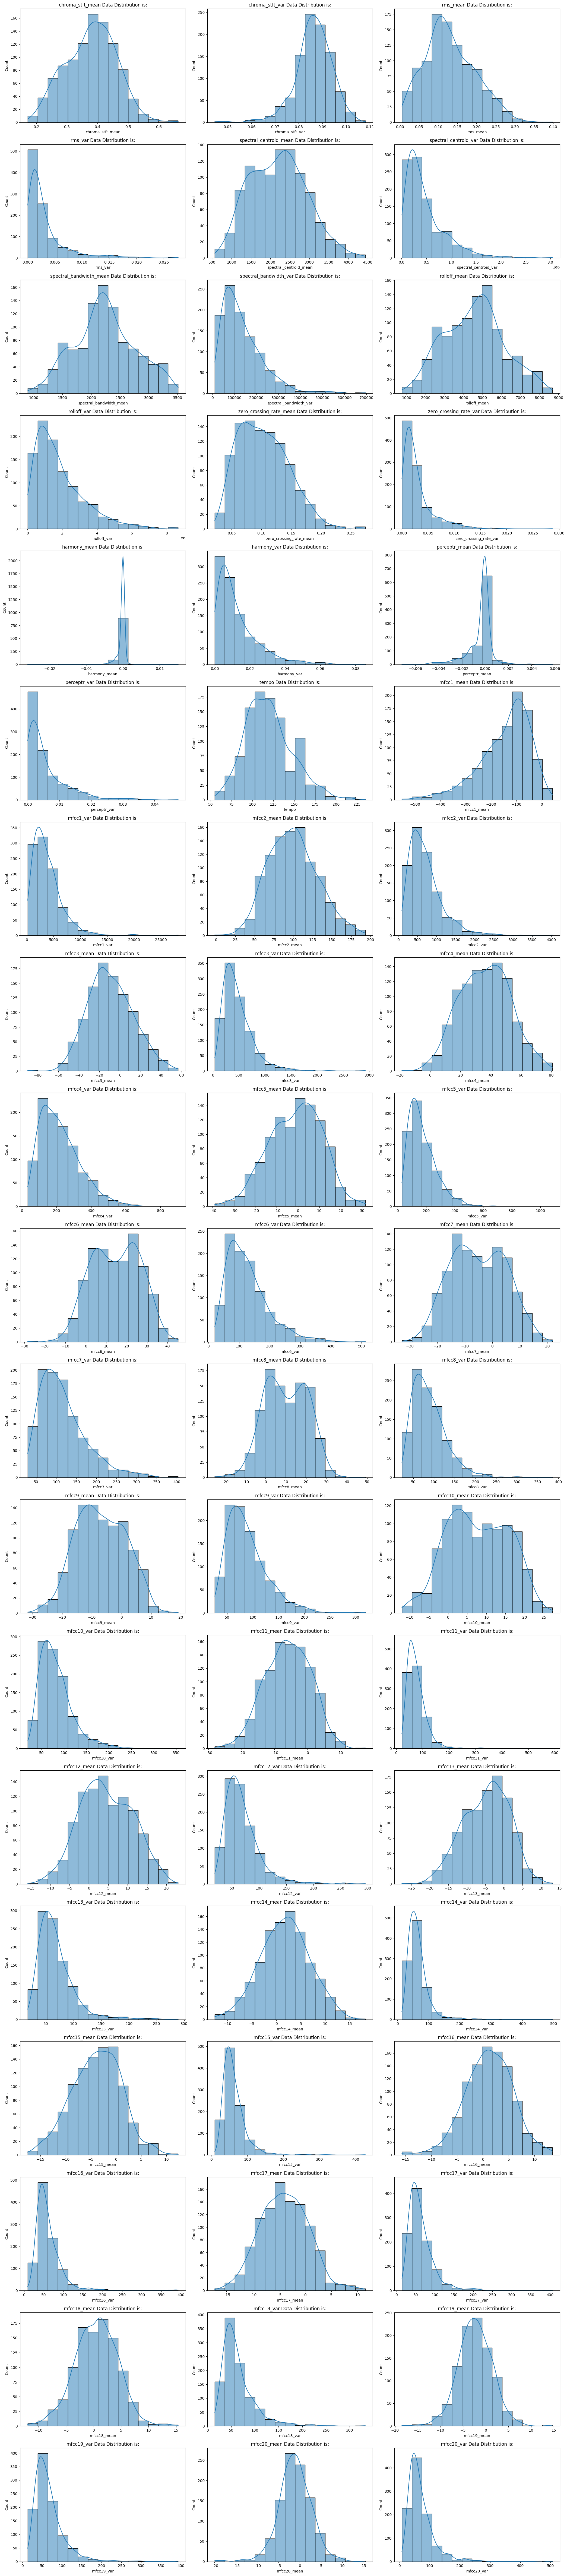


Applied Ordinal Encoding on Categorical columns.


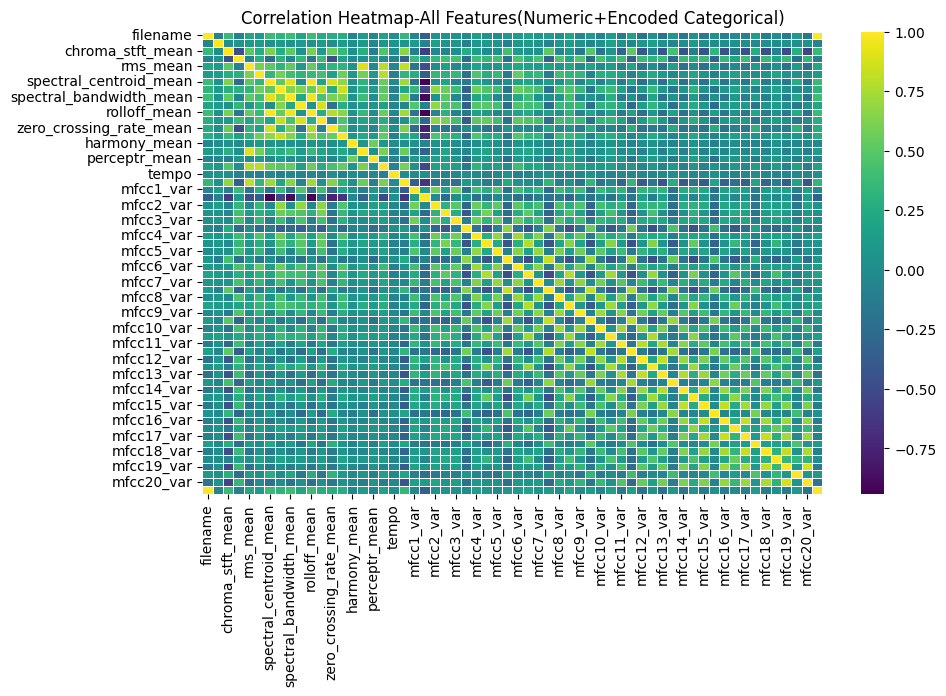

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0       0.0  661794          0.350088         0.088757  0.130228  0.002827   
1       1.0  661794          0.340914         0.094980  0.095948  0.002373   
2       2.0  661794          0.363637         0.085275  0.175570  0.002746   
3       3.0  661794          0.404785         0.093999  0.141093  0.006346   
4       4.0  661794          0.308526         0.087841  0.091529  0.002303   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1784.165850          129774.064525              2002.449060   
1             1530.176679          375850.073649              2039.036516   
2             1552.811865          156467.643368              1747.702312   
3             1070.106615          184355.942417              1596.412872   
4             1835.004266          343399.939274              1748.172116   

   spectral_bandwidth_var  ...  mfcc16_var  mfcc17_mean  mfcc17_var  \
0            85882.761315  ...   52.420910    -1.690215   36.524071   
1           213843.755497  ...   55.356403    -0.731125   60.314529   
2            76254.192257  ...   40.598766    -7.729093   47.639427   
3           166441.494769  ...   44.427753    -3.319597   50.206673   
4            88445.209036  ...   86.099236    -5.454034   75.269707   

   mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  mfcc20_mean  mfcc20_var  \
0    -0.408979   41.597103    -2.303523   55.062923     1.221291   46.936035   
1     0.295073   48.120598    -0.283518   51.106190     0.531217   45.786282   
2    -1.816407   52.382141    -3.439720   46.639660    -2.231258   30.573025   
3     0.636965   37.319130    -0.619121   37.259739    -3.407448   31.949339   
4    -0.916874   53.613918    -4.404827   62.910812   -11.703234   55.195160   

   label  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  

[5 rows x 60 columns]

In [5]:
# Checking basic info for 30-second dataset
print("=== 30-SECOND DATASET ===")
df_30sec.info()
print("Shape of 30-second dataset is:",df_30sec.shape)
print("Target variable distribution is:")
print(df_30sec['label'].value_counts())

# Separating numeric and categorical columns for 30-second
numeric_columns_30sec=df_30sec.select_dtypes(include=['int64','float64']).columns.tolist()
string_columns_30sec=df_30sec.select_dtypes(include=['object']).columns.tolist()
print("Numeric Columns:",numeric_columns_30sec)
print("Categorical Columns:",string_columns_30sec)

# Checking missing values for 30-second
print("Missing Values per Column in 30-second Dataset:")
print(df_30sec.isnull().sum())

# Checking unique counts of numerical columns
if numeric_columns_30sec:
    print("\nUnique value counts (numerical columns):")
    print(df_30sec[numeric_columns_30sec].nunique())

# Checking unique counts of categorical columns
if string_columns_30sec:
    print("\nUnique value counts (categorical columns):")
    print(df_30sec[string_columns_30sec].nunique())

# Handling missing values for 30-second
df_30sec[numeric_columns_30sec]=df_30sec[numeric_columns_30sec].apply(lambda x:x.fillna(x.mean()))
if string_columns_30sec:
    df_30sec[string_columns_30sec]=df_30sec[string_columns_30sec].apply(lambda x:x.fillna(x.mode()[0]))

# Dropping useless columns (only 1 unique value) for 30-second
df_30sec=df_30sec.drop(columns=df_30sec.columns[df_30sec.nunique()==1])

# Resetting index after cleaning in same dataset
df_30sec.reset_index(drop=True,inplace=True)

# Shape of dataset after cleaning
print("\nShape after cleaning:",df_30sec.shape)

# Quick descriptive stats for dataset
print("\nStatistical summary of numeric features:")
print(df_30sec[numeric_columns_30sec].describe().T)

# Quantile distribution for numeric columns
print("\nQuantile distribution of numeric columns:")
print(df_30sec[numeric_columns_30sec].quantile([0.25,0.5,0.75]).T)

#Quantile Visualization using Seaborn ---
columns_visualize_30sec=numeric_columns_30sec[1:59]

num_plots=len(columns_visualize_30sec)
num_cols_per_row=3
num_rows=math.ceil(num_plots/num_cols_per_row)
plt.figure(figsize=(num_cols_per_row*7,num_rows*5)) 

for i,col in enumerate(columns_visualize_30sec):
    plt.subplot(num_rows,num_cols_per_row,i+1)
    sns.histplot(df_30sec[col],kde=True,bins=15,edgecolor='k')
    plt.title(f'{col} Data Distribution is:')
plt.tight_layout()
plt.show()

# --- Categorical Handling ---
if string_columns_30sec:
    encoder=OrdinalEncoder()
    df_30sec[string_columns_30sec]=encoder.fit_transform(df_30sec[string_columns_30sec])
    print("\nApplied Ordinal Encoding on Categorical columns.")

# Correlation heatmap (numeric + encoded categorical)
plt.figure(figsize=(10,6))
sns.heatmap(df_30sec.corr(),annot=False,cmap="viridis",linewidth=0.4)
plt.title("Correlation Heatmap-All Features(Numeric+Encoded Categorical)")
plt.show()

#Showing first 5 rows after preprocessing
df_30sec.head()



### 4. Visualizing Genre Distributions

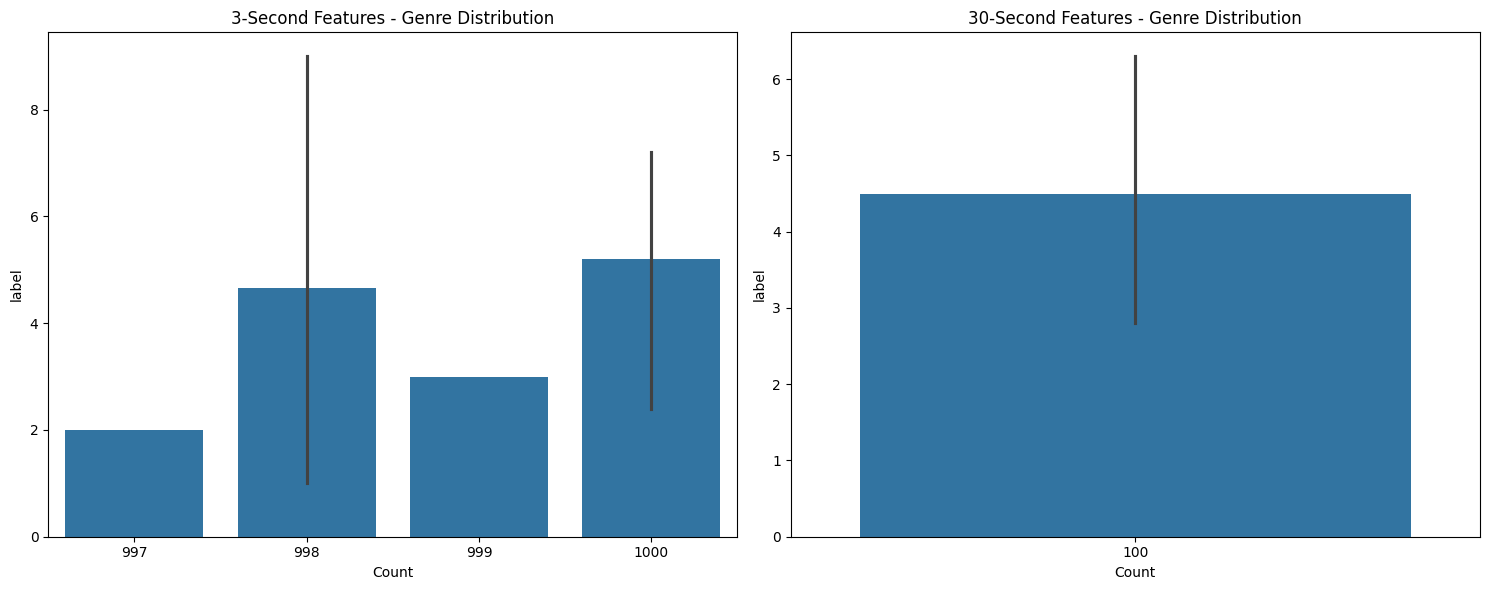

In [6]:
# Genre distribution visualization
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,6))
genre_counts_3sec=df_3sec['label'].value_counts()
genre_counts_30sec=df_30sec['label'].value_counts()
sns.barplot(x=genre_counts_3sec.values,y=genre_counts_3sec.index,ax=ax1)
ax1.set_title('3-Second Features - Genre Distribution')
ax1.set_xlabel('Count')

sns.barplot(x=genre_counts_30sec.values,y=genre_counts_30sec.index,ax=ax2)
ax2.set_title('30-Second Features - Genre Distribution')
ax2.set_xlabel('Count')

plt.tight_layout()
plt.show()

### 5. Training Tabular  Models on 3-Second Feature Dataset

In [7]:

print("----- TRAINING ON 3-SECOND DATASET -----")

x_3sec=df_3sec.drop(["label","filename"],axis=1)
y_3sec=df_3sec["label"]
x_train_3sec,x_test_3sec,y_train_3sec,y_test_3sec=train_test_split(x_3sec,y_3sec,test_size=0.25,random_state=42,stratify=y_3sec)

#scaler_3sec = StandardScaler()
#x_train_scaled_3sec = scaler_3sec.fit_transform(x_train_3sec)
#x_test_scaled_3sec = scaler_3sec.transform(x_test_3sec)

print("Training Random Forest on 3-second features...")
randf_3sec=RandomForestClassifier(n_estimators=5,max_depth=3,random_state=42)
randf_3sec.fit(x_train_3sec,y_train_3sec)
y_pred_randf_3sec=randf_3sec.predict(x_test_3sec)

print("Training XGBoost on 3-second features...")
labelencoder_3sec=LabelEncoder()
y_train_encoded_3sec=labelencoder_3sec.fit_transform(y_train_3sec)
y_test_encoded_3sec=labelencoder_3sec.transform(y_test_3sec)
xgb_3sec=XGBClassifier(n_estimators=5,max_depth=3,random_state=42,eval_metric="mlogloss")
xgb_3sec.fit(x_train_3sec,y_train_encoded_3sec)
y_pred_xgb_3sec=xgb_3sec.predict(x_test_3sec)


print("3-second Results:")
print("Random Forest Accuracy:",accuracy_score(y_test_3sec,y_pred_randf_3sec))
print("Random Forest Precision,Recall,F-1 :",classification_report(y_test_3sec,y_pred_randf_3sec))
print("XGBoost Accuracy:",accuracy_score(y_test_encoded_3sec, y_pred_xgb_3sec))
print("XGBoost Precision,Recall,F-1 :",classification_report(y_test_encoded_3sec,y_pred_xgb_3sec))  


----- TRAINING ON 3-SECOND DATASET -----
Training Random Forest on 3-second features...
Training XGBoost on 3-second features...
3-second Results:
Random Forest Accuracy: 0.40832666132906326
Random Forest Precision,Recall,F-1 :               precision    recall  f1-score   support

         0.0       0.25      0.43      0.32       250
         1.0       0.65      0.90      0.75       250
         2.0       0.35      0.19      0.25       249
         3.0       0.16      0.03      0.05       250
         4.0       0.50      0.24      0.32       249
         5.0       0.30      0.07      0.12       250
         6.0       0.45      0.85      0.59       250
         7.0       0.41      0.81      0.55       250
         8.0       0.36      0.55      0.43       250
         9.0       0.25      0.02      0.03       250

    accuracy                           0.41      2498
   macro avg       0.37      0.41      0.34      2498
weighted avg       0.37      0.41      0.34      2498

XGBoost Accur

### 6. Training Tabular Models on 30-Second Feature Dataset

In [8]:

print("----- TRAINING ON 30-SECOND DATASET -----")

x_30sec=df_30sec.drop(["label","filename"],axis=1)
y_30sec=df_30sec["label"]
x_train_30sec,x_test_30sec,y_train_30sec,y_test_30sec=train_test_split(x_30sec,y_30sec,test_size=0.25,random_state=42,stratify=y_30sec)

#scaler_30sec=StandardScaler()
#x_train_scaled_30sec=scaler_30sec.fit_transform(x_train_30sec)
#x_test_scaled_30sec=scaler_30sec.transform(x_test_30sec)

print("Training Random Forest on 30-second features...")
randf_30sec=RandomForestClassifier(n_estimators=5,max_depth=3,random_state=42)
randf_30sec.fit(x_train_30sec,y_train_30sec)
y_pred_randf_30sec=randf_30sec.predict(x_test_30sec)


print("Training XGBoost on 30-second features...")
labelencoder_30sec=LabelEncoder()
y_train_encoded_30sec=labelencoder_30sec.fit_transform(y_train_30sec)
y_test_encoded_30sec=labelencoder_30sec.transform(y_test_30sec)
xgb_30sec=XGBClassifier(n_estimators=5,max_depth=3,random_state=42,eval_metric="mlogloss")
xgb_30sec.fit(x_train_30sec,y_train_encoded_30sec)
y_pred_xgb_30sec=xgb_30sec.predict(x_test_30sec)


print("30-second Results:")
print("Random Forest Accuracy:",accuracy_score(y_test_30sec,y_pred_randf_30sec))
print("Random Forest Precision,Recall,F-1 :",classification_report(y_test_30sec,y_pred_randf_30sec))
print("XGBoost Accuracy:",accuracy_score(y_test_encoded_30sec, y_pred_xgb_30sec))
print("XGBoost Precision,Recall,F-1 :",classification_report(y_test_encoded_30sec,y_pred_xgb_30sec))  



----- TRAINING ON 30-SECOND DATASET -----
Training Random Forest on 30-second features...
Training XGBoost on 30-second features...
30-second Results:
Random Forest Accuracy: 0.5
Random Forest Precision,Recall,F-1 :               precision    recall  f1-score   support

         0.0       0.50      0.52      0.51        25
         1.0       0.71      0.96      0.81        25
         2.0       0.50      0.08      0.14        25
         3.0       0.39      0.44      0.42        25
         4.0       0.56      0.20      0.29        25
         5.0       0.63      0.68      0.65        25
         6.0       0.62      0.64      0.63        25
         7.0       0.57      1.00      0.72        25
         8.0       0.00      0.00      0.00        25
         9.0       0.23      0.48      0.31        25

    accuracy                           0.50       250
   macro avg       0.47      0.50      0.45       250
weighted avg       0.47      0.50      0.45       250

XGBoost Accuracy: 0.672
X

### 7. Feature Importance for 3-Second Feature Dataset

3-second Random Forest Feature Importance (Top 20):
                    Columns  Importance
6   spectral_bandwidth_mean    0.157270
18                mfcc1_var    0.099386
3                   rms_var    0.090777
5     spectral_centroid_var    0.073612
7    spectral_bandwidth_var    0.070247
17               mfcc1_mean    0.069329
9               rolloff_var    0.066042
33               mfcc9_mean    0.064341
0          chroma_stft_mean    0.048126
31               mfcc8_mean    0.038221
15             perceptr_var    0.035679
13              harmony_var    0.031823
4    spectral_centroid_mean    0.028779
41              mfcc13_mean    0.027599
27               mfcc6_mean    0.025054
23               mfcc4_mean    0.022444
39              mfcc12_mean    0.018100
2                  rms_mean    0.008204
22                mfcc3_var    0.007628
35              mfcc10_mean    0.007509


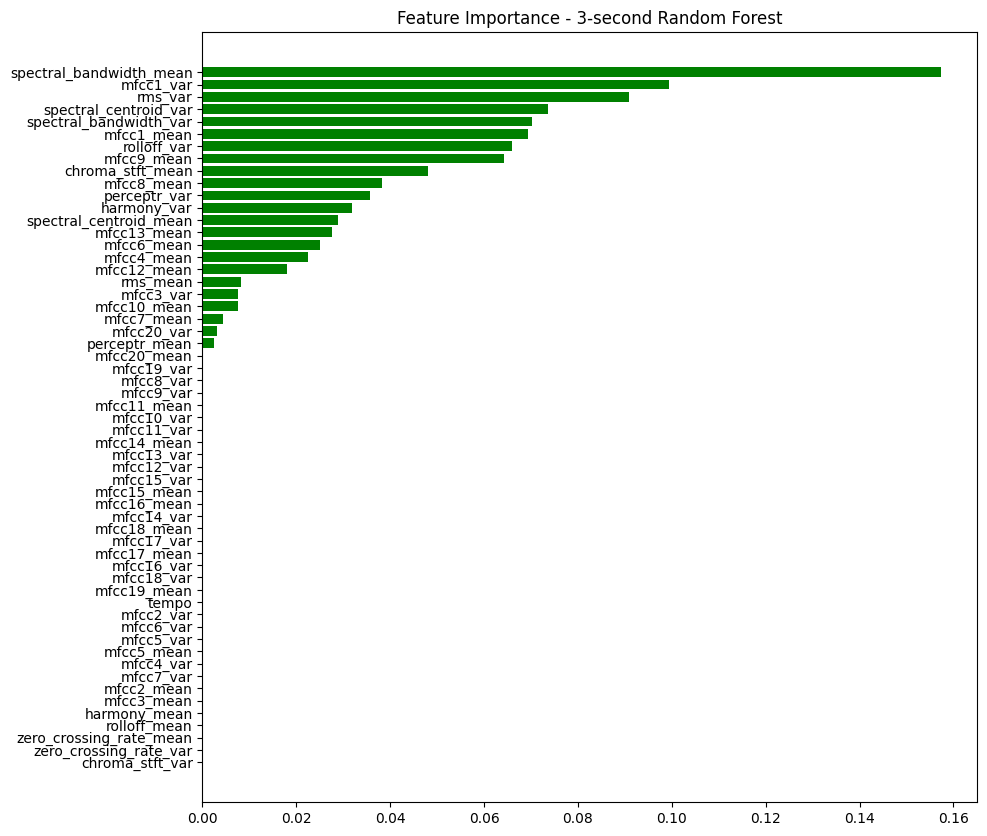

3-second XGBoost Feature Importance (Top 20):
                    Columns  Importance
1           chroma_stft_var    0.087008
15             perceptr_var    0.061604
6   spectral_bandwidth_mean    0.059016
39              mfcc12_mean    0.038736
18                mfcc1_var    0.036676
17               mfcc1_mean    0.031049
54               mfcc19_var    0.030453
24                mfcc4_var    0.029259
8              rolloff_mean    0.027784
23               mfcc4_mean    0.027600
0          chroma_stft_mean    0.027194
9               rolloff_var    0.026636
13              harmony_var    0.025097
50               mfcc17_var    0.023710
5     spectral_centroid_var    0.022634
55              mfcc20_mean    0.021765
10  zero_crossing_rate_mean    0.021542
26                mfcc5_var    0.021134
3                   rms_var    0.020884
16                    tempo    0.018061


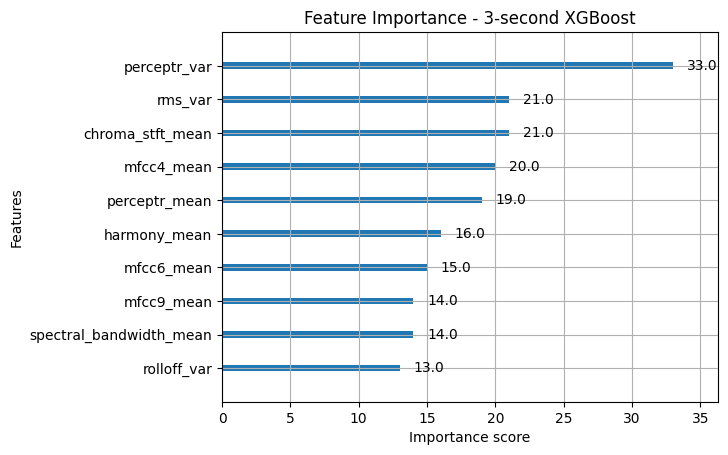

In [9]:

# Feature importance for 3-second Random Forest
feat_imp_randf_3sec=pd.DataFrame({'Columns':x_3sec.columns,'Importance':randf_3sec.feature_importances_})
print("3-second Random Forest Feature Importance (Top 20):")
print(feat_imp_randf_3sec.sort_values(by='Importance',ascending=False).head(20))

plt.figure(figsize=(10,10))
feat_imp_randf_3sec_sorted=feat_imp_randf_3sec.sort_values(by='Importance',ascending=True).reset_index(drop=True)
plt.barh(feat_imp_randf_3sec_sorted['Columns'],feat_imp_randf_3sec_sorted['Importance'],color='green')
plt.title('Feature Importance - 3-second Random Forest')
plt.show()

# Feature importance for 3-second XGBoost
feat_imp_xgb_3sec=pd.DataFrame({'Columns':x_3sec.columns,'Importance':xgb_3sec.feature_importances_})
print("3-second XGBoost Feature Importance (Top 20):")
print(feat_imp_xgb_3sec.sort_values(by='Importance',ascending=False).head(20))
plot_importance(xgb_3sec,importance_type='weight',max_num_features=10)
plt.title('Feature Importance - 3-second XGBoost')
plt.show()

### 8. Feature Importance for 30-Second Feature Dataset

30-second Random Forest Feature Importance (Top 20):
                    Columns  Importance
0                    length    0.127009
24               mfcc4_mean    0.080195
2           chroma_stft_var    0.068609
16             perceptr_var    0.063986
18               mfcc1_mean    0.057499
7   spectral_bandwidth_mean    0.054313
4                   rms_var    0.050102
42              mfcc13_mean    0.047312
9              rolloff_mean    0.045592
1          chroma_stft_mean    0.045011
3                  rms_mean    0.042534
34               mfcc9_mean    0.041469
28               mfcc6_mean    0.040842
40              mfcc12_mean    0.032678
43               mfcc13_var    0.031704
31                mfcc7_var    0.030377
55               mfcc19_var    0.024361
27                mfcc5_var    0.021919
14              harmony_var    0.020553
29                mfcc6_var    0.017541


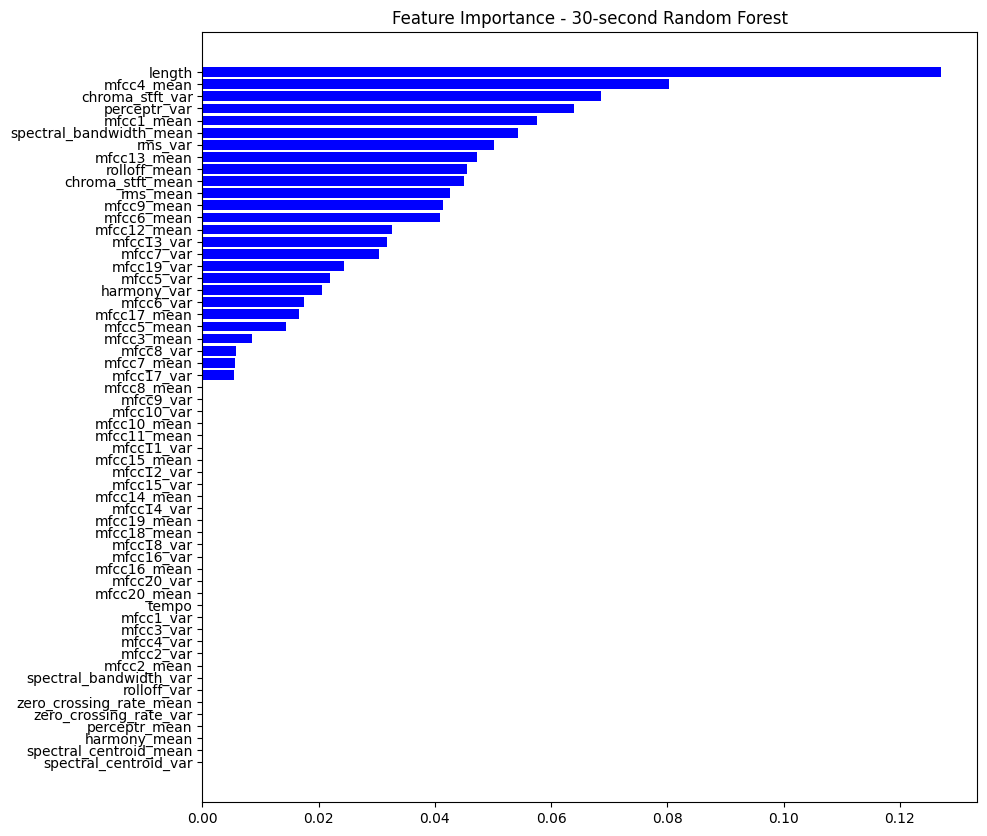

30-second XGBoost Feature Importance (Top 20):
                    Columns  Importance
16             perceptr_var    0.067669
7   spectral_bandwidth_mean    0.058172
2           chroma_stft_var    0.052211
40              mfcc12_mean    0.044959
6     spectral_centroid_var    0.036145
34               mfcc9_mean    0.031109
14              harmony_var    0.030740
11  zero_crossing_rate_mean    0.029938
27                mfcc5_var    0.029712
38              mfcc11_mean    0.028252
19                mfcc1_var    0.027487
0                    length    0.026805
9              rolloff_mean    0.026579
30               mfcc7_mean    0.026229
1          chroma_stft_mean    0.026068
24               mfcc4_mean    0.022202
46              mfcc15_mean    0.022201
4                   rms_var    0.021358
31                mfcc7_var    0.020654
13             harmony_mean    0.019976


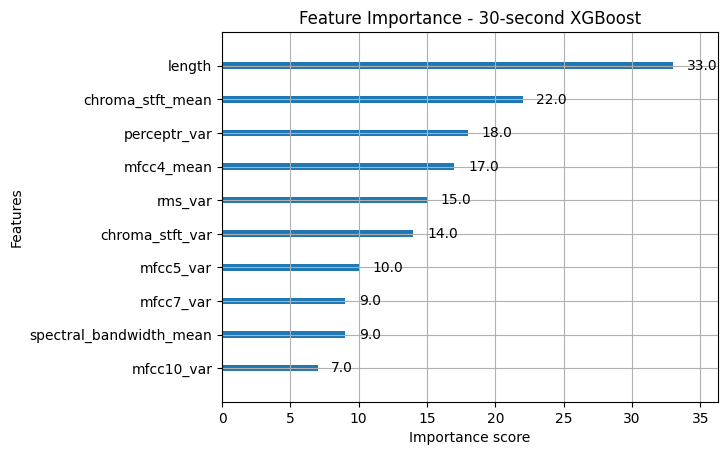

In [10]:

# Feature importance for 30-second Random Forest
feat_imp_randf_30sec=pd.DataFrame({'Columns':x_30sec.columns,'Importance':randf_30sec.feature_importances_})
print("30-second Random Forest Feature Importance (Top 20):")
print(feat_imp_randf_30sec.sort_values(by='Importance',ascending=False).head(20))

plt.figure(figsize=(10, 10))
feat_imp_randf_30sec_sorted=feat_imp_randf_30sec.sort_values(by='Importance',ascending=True).reset_index(drop=True)
plt.barh(feat_imp_randf_30sec_sorted['Columns'],feat_imp_randf_30sec_sorted['Importance'],color='blue')
plt.title('Feature Importance - 30-second Random Forest')
plt.show()

# Feature importance for 30-second XGBoost
feat_imp_xgb_30sec=pd.DataFrame({'Columns':x_30sec.columns,'Importance':xgb_30sec.feature_importances_})
print("30-second XGBoost Feature Importance (Top 20):")
print(feat_imp_xgb_30sec.sort_values(by='Importance',ascending=False).head(20))
plot_importance(xgb_30sec,importance_type='weight',max_num_features=10)
plt.title('Feature Importance - 30-second XGBoost')
plt.show()



### 9. Confusion Matrix for 3-Second Feature Dataset

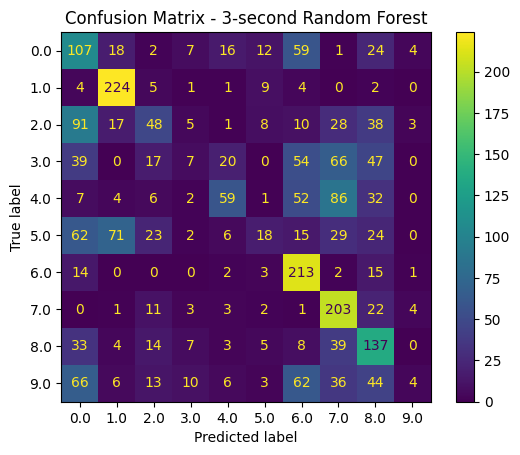

<Figure size 2000x1000 with 0 Axes>

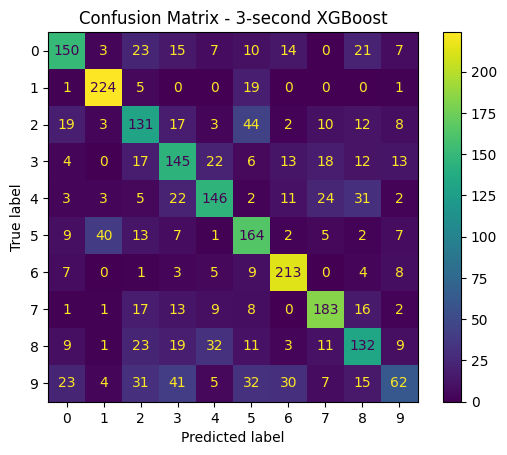

<Figure size 2000x1000 with 0 Axes>

In [11]:

# Confusion matrix for 3-second Random Forest
cm_randf_3sec=confusion_matrix(y_test_3sec,y_pred_randf_3sec)
disp_randf_3sec=ConfusionMatrixDisplay(confusion_matrix=cm_randf_3sec,display_labels=randf_3sec.classes_)
disp_randf_3sec.plot(cmap='viridis')
plt.title('Confusion Matrix - 3-second Random Forest')
plt.figure(figsize=(20,10))
plt.tight_layout()
plt.show()

# Confusion matrix for 3-second XGBoost
cm_xgb_3sec=confusion_matrix(y_test_encoded_3sec,y_pred_xgb_3sec)
disp_xgb_3sec=ConfusionMatrixDisplay(confusion_matrix=cm_xgb_3sec,display_labels=xgb_3sec.classes_)
disp_xgb_3sec.plot(cmap='viridis')
plt.title('Confusion Matrix - 3-second XGBoost')
plt.figure(figsize=(20,10))
plt.tight_layout()
plt.show()

### 10. Confusion Matrix for 30-Second Feature Dataset


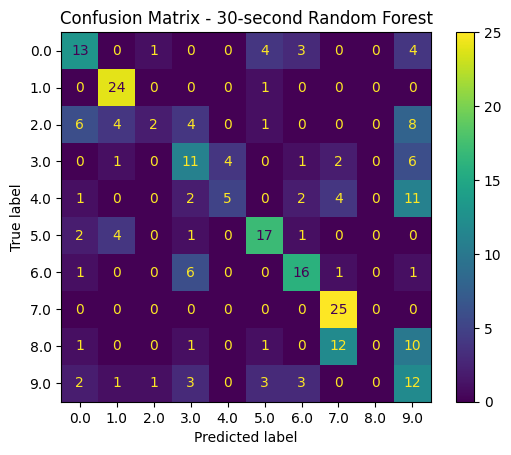

<Figure size 2000x1000 with 0 Axes>

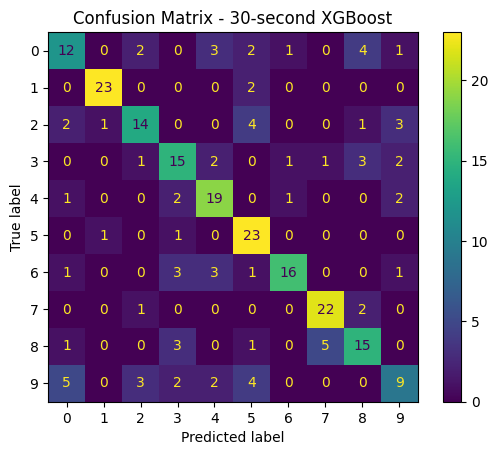

<Figure size 2000x1000 with 0 Axes>

In [12]:

# Confusion matrix for 30-second Random Forest
cm_randf_30sec=confusion_matrix(y_test_30sec,y_pred_randf_30sec)
disp_randf_30sec=ConfusionMatrixDisplay(confusion_matrix=cm_randf_30sec,display_labels=randf_30sec.classes_)
disp_randf_30sec.plot(cmap='viridis')
plt.title('Confusion Matrix - 30-second Random Forest')
plt.figure(figsize=(20,10))
plt.tight_layout()
plt.show()

# Confusion matrix for 30-second XGBoost
cm_xgb_30sec=confusion_matrix(y_test_encoded_30sec,y_pred_xgb_30sec)
disp_xgb_30sec=ConfusionMatrixDisplay(confusion_matrix=cm_xgb_30sec,display_labels=xgb_30sec.classes_)
disp_xgb_30sec.plot(cmap='viridis')
plt.title('Confusion Matrix - 30-second XGBoost')
plt.figure(figsize=(20,10))
plt.tight_layout()
plt.show()

### 11. Loading Audio Files and Extracting MFCC Features with Librosa

In [13]:
print("----- LOADING AUDIO FILES AND EXTRACTING MFCC FEATURES ----")

# Loading audio files from genres_original folder and extract MFCC features
mfcc_features=[]
mfcc_labels=[]
mfcc_genre_mapping={}

# Getting all genre folders from genres_original
audio_genre_folders=['blues',
                    'classical',
                    'country',
                    'disco',
                    'hiphop',
                    'jazz',
                    'metal',
                    'pop',
                    'reggae',
                    'rock']

for i,genre in enumerate(audio_genre_folders):
    genre_path=f"genres_original/{genre}"
    mfcc_genre_mapping[genre]=i
    count=0
    
    #1. Getting all WAV files in the genre folder
    #2. Loading audio files with librosa
    #3. Extracting MFCC features from audio files
    #4. Taking mean across time to get a single feature vector per audio file

    import os
    wav_files=[f for f in os.listdir(genre_path) if f.endswith('.wav')]

    for wav_file in wav_files[:50]:  # Limiting to 50 audio files per genre
        wav_path=f"{genre_path}/{wav_file}"
        y,sr=librosa.load(wav_path,duration=30) 
        mfccs=librosa.feature.mfcc(y=y,sr=sr,n_mfcc=13)
        mfcc_mean=np.mean(mfccs,axis=1)
        mfcc_features.append(mfcc_mean)
        mfcc_labels.append(i)
        count+=1
x_mfcc=np.array(mfcc_features)
y_mfcc=np.array(mfcc_labels)

print(f"Loaded {len(x_mfcc)} audio files with {len(mfcc_genre_mapping)} genres.")
print("MFCC features shape:", x_mfcc.shape)
print("MFCC genre mapping:", mfcc_genre_mapping)

----- LOADING AUDIO FILES AND EXTRACTING MFCC FEATURES ----
Loaded 500 audio files with 10 genres.
MFCC features shape: (500, 13)
MFCC genre mapping: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


### 12. Training Tabular Models on MFCC Features

In [24]:

print("----- TRAINING ON MFCC FEATURES -----")
x_train_mfcc,x_test_mfcc,y_train_mfcc,y_test_mfcc=train_test_split(x_mfcc,y_mfcc,test_size=0.25,random_state=42,stratify=y_mfcc)

# Scale MFCC features
#scaler_mfcc=StandardScaler()
#x_train_mfcc_scaled=scaler_mfcc.fit_transform(x_train_mfcc)
#x_test_mfcc_scaled=scaler_mfcc.transform(x_test_mfcc)

# Random Forest on MFCC features
print("Training Random Forest on MFCC features...")
randf_mfcc=RandomForestClassifier(n_estimators=5,max_depth=3,random_state=42)
randf_mfcc.fit(x_train_mfcc,y_train_mfcc)
y_pred_randf_mfcc=randf_mfcc.predict(x_test_mfcc)

# XGBoost on MFCC features
print("Training XGBoost on MFCC features...")
labelencoder_mfcc=LabelEncoder()
y_train_encoded_mfcc=labelencoder_mfcc.fit_transform(y_train_mfcc)
y_test_encoded_mfcc=labelencoder_mfcc.transform(y_test_mfcc)
xgb_mfcc=XGBClassifier(n_estimators=5,max_depth=3,random_state=42,eval_metric="mlogloss")
xgb_mfcc.fit(x_train_mfcc,y_train_encoded_mfcc)
y_pred_xgb_mfcc=xgb_mfcc.predict(x_test_mfcc)

print("MFCC-based Results:")
print("Random Forest Accuracy:",accuracy_score(y_test_mfcc,y_pred_randf_mfcc))
print("Random Forest Precision,Recall,F-1 :",classification_report(y_test_mfcc,y_pred_randf_mfcc))
print("XGBoost Accuracy:",accuracy_score(y_test_encoded_mfcc,y_pred_xgb_mfcc))
print("XGBoost Precision,Recall,F-1 :",classification_report(y_test_encoded_mfcc,y_pred_xgb_mfcc))


----- TRAINING ON MFCC FEATURES -----
Training Random Forest on MFCC features...
Training XGBoost on MFCC features...
MFCC-based Results:
Random Forest Accuracy: 0.512
Random Forest Precision,Recall,F-1 :               precision    recall  f1-score   support

           0       0.43      0.50      0.46        12
           1       0.67      0.83      0.74        12
           2       0.50      0.46      0.48        13
           3       0.60      0.69      0.64        13
           4       0.33      0.08      0.12        13
           5       0.17      0.08      0.11        12
           6       0.58      0.85      0.69        13
           7       0.65      0.92      0.76        12
           8       0.45      0.75      0.56        12
           9       0.00      0.00      0.00        13

    accuracy                           0.51       125
   macro avg       0.44      0.52      0.46       125
weighted avg       0.44      0.51      0.45       125

XGBoost Accuracy: 0.528
XGBoost Prec

### 13. Feature Importance for MFCC Features

MFCC Random Forest Feature Importance:
    Columns  Importance
11  MFCC_12    0.186180
8    MFCC_9    0.182946
6    MFCC_7    0.149247
3    MFCC_4    0.142218
0    MFCC_1    0.080674
7    MFCC_8    0.070226
1    MFCC_2    0.060127
12  MFCC_13    0.046806
2    MFCC_3    0.033214
5    MFCC_6    0.030631
4    MFCC_5    0.011758
9   MFCC_10    0.005972
10  MFCC_11    0.000000


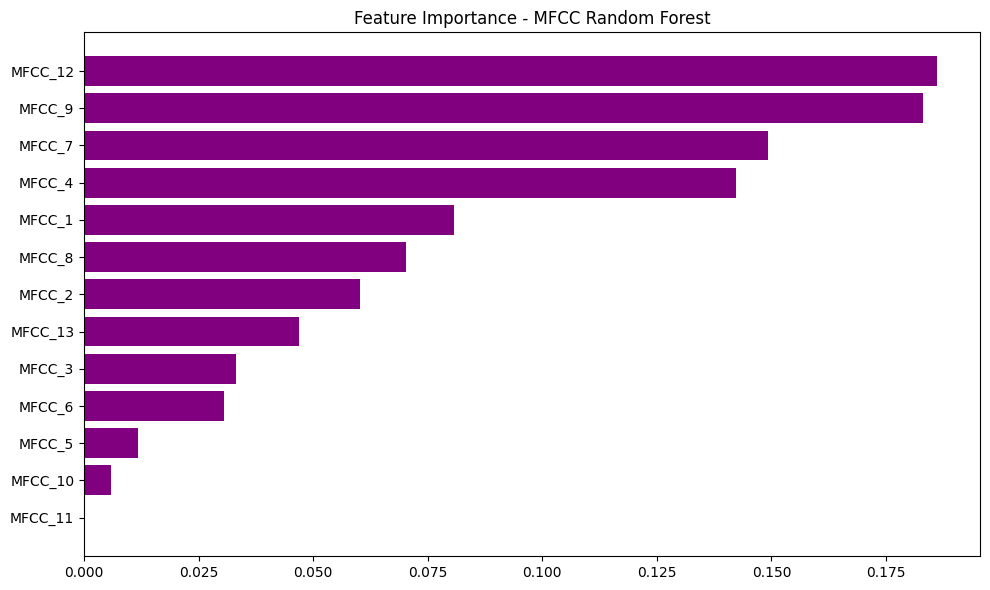

In [15]:
feat_imp_randf_mfcc=pd.DataFrame({'Columns':[f'MFCC_{i+1}' for i in range(13)],'Importance':randf_mfcc.feature_importances_})
print("MFCC Random Forest Feature Importance:")
print(feat_imp_randf_mfcc.sort_values(by='Importance',ascending=False))

plt.figure(figsize=(10,6))
feat_imp_randf_mfcc_sorted=feat_imp_randf_mfcc.sort_values(by='Importance',ascending=True).reset_index(drop=True)
plt.barh(feat_imp_randf_mfcc_sorted['Columns'],feat_imp_randf_mfcc_sorted['Importance'],color='purple')
plt.title('Feature Importance - MFCC Random Forest')
plt.tight_layout()
plt.show()

### 14. Confusion Matrix for MFCC Features

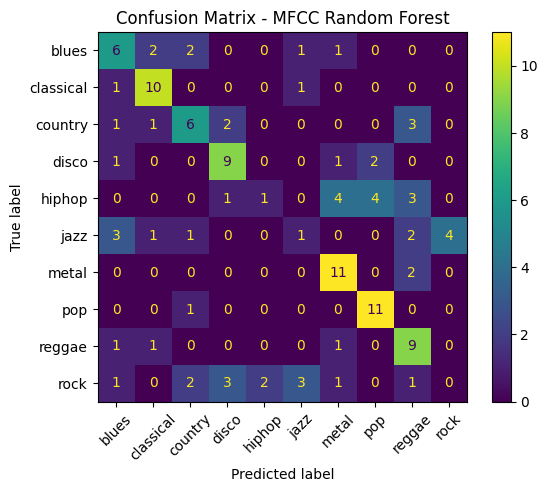

<Figure size 2000x1000 with 0 Axes>

In [16]:

# Confusion matrix for MFCC Random Forest
cm_randf_mfcc=confusion_matrix(y_test_mfcc,y_pred_randf_mfcc)
disp_randf_mfcc=ConfusionMatrixDisplay(confusion_matrix=cm_randf_mfcc,display_labels=list(mfcc_genre_mapping.keys()))
disp_randf_mfcc.plot(cmap='viridis',xticks_rotation=45)
plt.title('Confusion Matrix - MFCC Random Forest')
plt.figure(figsize=(20,10))
plt.tight_layout()
plt.show()


### 15. Loading Spectogram Images

In [17]:
print("----- LOADING SPECTROGRAM IMAGES -----")

# Load spectrogram images from images_original folder
images=[]
labels=[]
genre_mapping={}

# Get all genre folders from images_original
genre_folders = ['blues',
                'classical',
                'country',
                'disco',
                'hiphop',
                'jazz',
                'metal',
                'pop',
                'reggae',
                'rock']

for i,genre in enumerate(genre_folders):
    genre_path=f"images_original/{genre}"
    genre_mapping[genre]=i
    count=0
    
    # Getting all PNG files in the genre folder
    png_files=[f for f in os.listdir(genre_path) if f.endswith('.png')]
    for img_file in png_files[:100]:  # Limiting to 100 images per genre
        img_path=f"{genre_path}/{img_file}"
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(128,128)) 
        img=img/255.0  # Normalizing pixel values
        images.append(img)
        labels.append(i)
        count+=1
x_images=np.array(images)
y_images=np.array(labels)

print(f"Loaded {len(x_images)} images with {len(genre_mapping)} genres.")
print("Genre mapping:",genre_mapping)

----- LOADING SPECTROGRAM IMAGES -----
Loaded 999 images with 10 genres.
Genre mapping: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


### 16. Training CNN on Spectogram Images

----- TRAINING CUSTOM CNN -----
Custom CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,268,298 (12.47 MB)

 Trainable params: 3,268,298 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.0961 - loss: 2.3398 - val_accuracy: 0.1240 - val_loss: 2.2629
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.1575 - loss: 2.2151 - val_accuracy: 0.1600 - val_loss: 2.1208
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.2029 - loss: 2.1262 - val_accuracy: 0.3320 - val_loss: 2.0278
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.2403 - loss: 2.0094 - val_accuracy: 0.2840 - val_loss: 1.8765
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.3191 - loss: 1.8775 - val_accuracy: 0.3840 - val_loss: 1.8638
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.3271 - loss: 1.8241 - val_accuracy: 0.4400 - val_loss: 1.6295
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.3805 - loss: 1.6607 - val_accuracy: 0.4320 - val_loss: 1.6050
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.3525 - loss: 1.7125 - val_accuracy: 0.

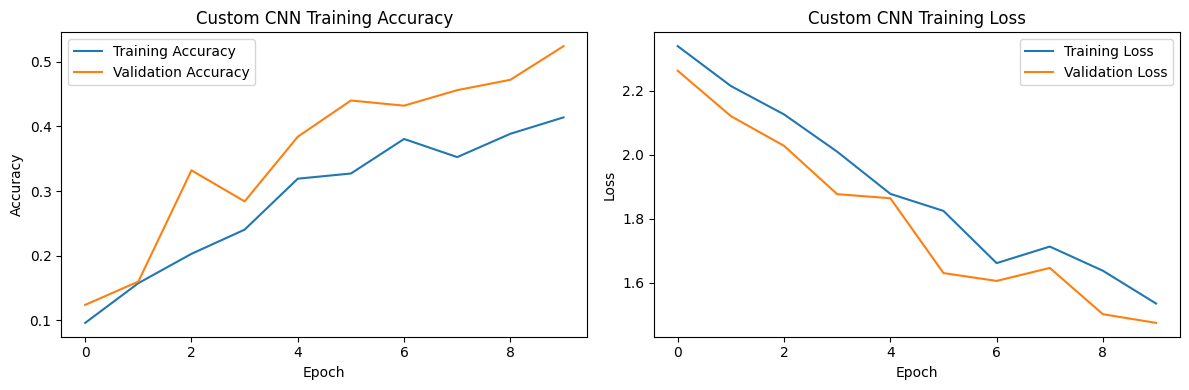

In [18]:

print("----- TRAINING CUSTOM CNN -----")
x_train_img,x_test_img,y_train_img,y_test_img =train_test_split(x_images,y_images,test_size=0.25,random_state=42,stratify=y_images)

#using encoding to convert labels to int categorical 
y_train_cat=OrdinalEncoder().fit_transform(y_train_img.reshape(-1,1)).astype(int)
y_test_cat=OrdinalEncoder().fit_transform(y_test_img.reshape(-1,1)).astype(int)


# Building custom CNN model
cnn=Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)),MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),Flatten(),
    Dense(64,activation='relu'),Dropout(0.5),
    Dense(len(genre_mapping),activation='softmax')
])

cnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

print("Custom CNN Model Summary:")
cnn.summary()
cnn_model=cnn.fit(x_train_img,y_train_cat,epochs=10,batch_size=32,validation_data=(x_test_img,y_test_cat),verbose=1)

# Evaluateing custom CNN model
cnn_model_loss,cnn_model_acc=cnn.evaluate(x_test_img,y_test_cat,verbose=1)
print(f"Custom CNN Test Accuracy:{cnn_model_acc:.2f}")
print(f"Custom CNN Test Loss:{cnn_model_loss:.2f}")

# Plotting training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(cnn_model.history['accuracy'],label='Training Accuracy')
plt.plot(cnn_model.history['val_accuracy'],label='Validation Accuracy')
plt.title('Custom CNN Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(cnn_model.history['loss'],label='Training Loss')
plt.plot(cnn_model.history['val_loss'],label='Validation Loss')
plt.title('Custom CNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

### 17. Transfer Learning Model


-----TRAINING TRANSFER LEARNING MODELS -----
Training VGG16 transfer learning model...
VGG16 Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,111,242 (57.64 MB)

 Trainable params: 396,554 (1.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.0921 - loss: 2.4321 - val_accuracy: 0.1000 - val_loss: 2.2947 - learning_rate: 0.0010
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.1242 - loss: 2.3077 - val_accuracy: 0.1560 - val_loss: 2.2428 - learning_rate: 0.0010
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.1535 - loss: 2.2572 - val_accuracy: 0.2200 - val_loss: 2.1995 - learning_rate: 0.0010
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.1696 - loss: 2.1820 - val_accuracy: 0.2400 - val_loss: 2.1172 - learning_rate: 0.0010
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.2016 - loss: 2.0960 - val_accuracy: 0.2200 - val_loss: 2.0840 - learning_rate: 0.0010
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.2443 - loss: 2.0539 - val_accuracy: 0.2920 - val_loss: 2.0137 - learning_rate: 0.0010
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.2403 - loss: 2.0398 - val_accuracy:

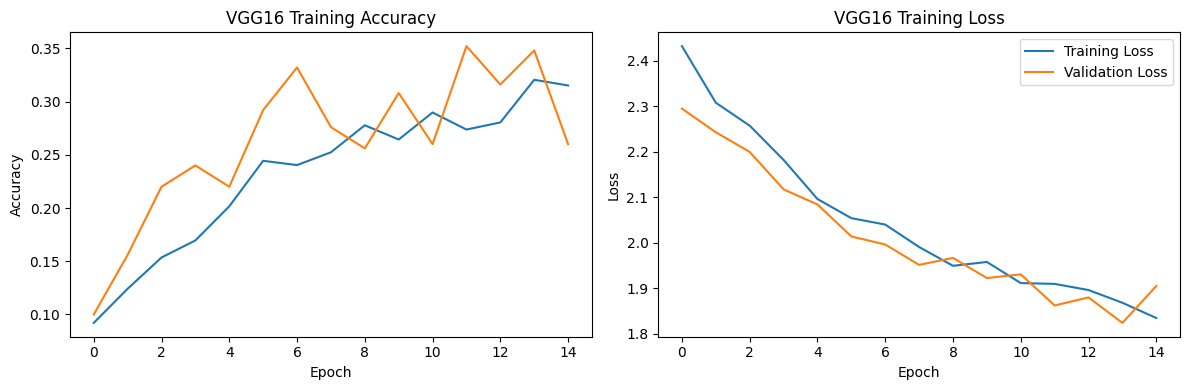

Training ResNet50 transfer learning model...
ResNet50 Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,770,698 (94.49 MB)

 Trainable params: 1,182,986 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 332ms/step - accuracy: 0.0961 - loss: 2.4709 - val_accuracy: 0.1000 - val_loss: 2.3214 - learning_rate: 0.0010
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 284ms/step - accuracy: 0.0975 - loss: 2.3623 - val_accuracy: 0.0680 - val_loss: 2.3053 - learning_rate: 0.0010
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - accuracy: 0.0988 - loss: 2.3334 - val_accuracy: 0.1000 - val_loss: 2.3027 - learning_rate: 0.0010
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 292ms/step - accuracy: 0.0708 - loss: 2.3282 - val_accuracy: 0.1000 - val_loss: 2.3011 - learning_rate: 2.0000e-04
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 285ms/step - accuracy: 0.1055 - loss: 2.3138 - val_accuracy: 0.1000 - val_loss: 2.2995 - learning_rate: 2.0000e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - accuracy: 0.1000 - loss: 2.3214
ResNet50 Transfer Learning Accuracy: 0.10000000149011612
ResNet50 Transfer Learning Loss: 2.3213655948638916


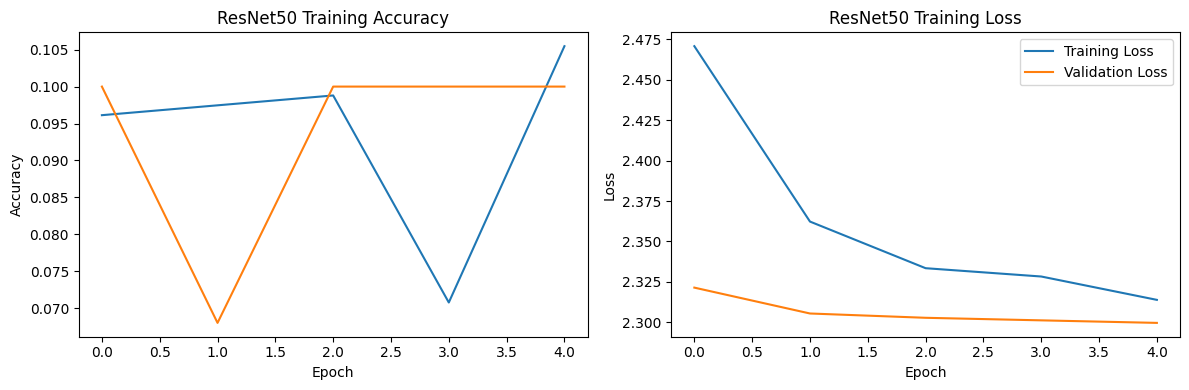

In [ ]:
print("-----TRAINING TRANSFER LEARNING MODELS -----")

datagen=ImageDataGenerator(rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True,fill_mode='nearest')

# Calback
early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3,min_lr=0.0001)

#VGG16 Transfer Learning
print("Training VGG16 transfer learning model...")
vgg=VGG16(weights='imagenet',include_top=False,input_shape=(128,128,3))
vgg.trainable=False

vgg_model=Sequential([
          vgg,GlobalAveragePooling2D(),Dense(512,activation='relu'),
          Dropout(0.5),Dense(256,activation='relu'),Dropout(0.3),
          Dense(len(genre_mapping),activation='softmax')])

vgg_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print("VGG16 Model Summary:")
vgg_model.summary()

vgg_history=vgg_model.fit(datagen.flow(x_train_img,y_train_cat,batch_size=16),epochs=15,validation_data=(x_test_img,y_test_cat),
            callbacks=[early_stopping,reduce_lr],verbose=1)

# Evaluating VGG16 model
vgg_model_loss,vgg_model_acc=vgg_model.evaluate(x_test_img,y_test_cat,verbose=1)
print(f"VGG16 Transfer Learning Accuracy is: {vgg_model_acc:.2f}:")
print(f"VGG16 Transfer Learning Loss is: {vgg_model_loss:.2f}")

# Plotting VGG16 training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(vgg_history.history['accuracy'],label='Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'],label='Validation Accuracy')
plt.title('VGG16 Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(vgg_history.history['loss'],label='Training Loss')
plt.plot(vgg_history.history['val_loss'],label='Validation Loss')
plt.title('VGG16 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


# ResNet50 Transfer Learning
print("Training ResNet50 transfer learning model...")
resnet=ResNet50(weights='imagenet',include_top=False,input_shape=(128,128,3))
resnet.trainable=False

resnet_model=Sequential([
            resnet,GlobalAveragePooling2D(),Dense(512,activation='relu'),
            Dropout(0.5),Dense(256,activation='relu'),Dropout(0.3),
            Dense(len(genre_mapping),activation='softmax')])

resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("ResNet50 Model Summary:")
resnet_model.summary()

resnet_hist=resnet_model.fit(datagen.flow(x_train_img,y_train_cat,batch_size=16),epochs=15,
    validation_data=(x_test_img,y_test_cat),callbacks=[early_stopping,reduce_lr],verbose=1)

# Evaluating ResNet50 model
resnet_model_loss,resnet_model_acc=resnet_model.evaluate(x_test_img,y_test_cat,verbose=1)
print(f"ResNet50 Transfer Learning Accuracy: {resnet_model_acc:.2f}")
print(f"ResNet50 Transfer Learning Loss: {resnet_model_loss:.2f}")

# Plotting ResNet50 training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(resnet_hist.history['accuracy'],label='Training Accuracy')
plt.plot(resnet_hist.history['val_accuracy'],label='Validation Accuracy')
plt.title('ResNet50 Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(resnet_hist.history['loss'],label='Training Loss')
plt.plot(resnet_hist.history['val_loss'],label='Validation Loss')
plt.title('ResNet50 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


### 18. Outcomes

In [25]:
print("----- SUMMARY STATISTICS -----")

tabular_accuracies=[accuracy_score(y_test_3sec,y_pred_randf_3sec),accuracy_score(y_test_encoded_3sec, y_pred_xgb_3sec),
                   accuracy_score(y_test_30sec,y_pred_randf_30sec),accuracy_score(y_test_encoded_30sec, y_pred_xgb_30sec)]
mfcc_accuracies=[accuracy_score(y_test_mfcc,y_pred_randf_mfcc),accuracy_score(y_test_encoded_mfcc,y_pred_xgb_mfcc)]
image_accuracies=[cnn_model_acc,vgg_model_acc,resnet_model_acc]

print(f"Average Tabular Approach Accuracy is: {np.mean(tabular_accuracies):.2f}")
print(f"Average MFCC Approach Accuracy is: {np.mean(mfcc_accuracies):.2f}")
print(f"Average Image-based Approach Accuracy is: {np.mean(image_accuracies):.2f}")
print(f"Best Tabular Model: {max(tabular_accuracies):.2f}")
print(f"Best MFCC Model: {max(mfcc_accuracies):2f}")
print(f"Best Image-based Model: {max(image_accuracies):.2f}")

print(f"\nFeature Duration Impact:")
print(f"3-sec vs 30-sec (RF):  {((accuracy_score(y_test_30sec,y_pred_randf_30sec)-accuracy_score(y_test_3sec,y_pred_randf_3sec))
                                /accuracy_score(y_test_3sec,y_pred_randf_3sec)*100):.2f}% improvement.")

print(f"3-sec vs 30-sec (XGB): {((accuracy_score(y_test_encoded_30sec,y_pred_xgb_30sec)-accuracy_score(y_test_encoded_3sec,y_pred_xgb_3sec))
                                /accuracy_score(y_test_encoded_3sec,y_pred_xgb_3sec)*100):.2f}% improvement.")

print(f"MFCC vs Tabular (RF):  {((accuracy_score(y_test_mfcc,y_pred_randf_mfcc)-accuracy_score(y_test_30sec,y_pred_randf_30sec))
                                /accuracy_score(y_test_30sec,y_pred_randf_30sec)*100):.2f}% improvement.")
print(f"MFCC vs Tabular (XGB): {((accuracy_score(y_test_encoded_mfcc,y_pred_xgb_mfcc)-accuracy_score(y_test_encoded_30sec, y_pred_xgb_30sec))
                                /accuracy_score(y_test_encoded_30sec, y_pred_xgb_30sec)*100):.2f}% improvement.")

print(f"\nPerformance Improvement with Transfer Learning:")
print(f"Custom CNN vs VGG16: {((vgg_model_acc-cnn_model_acc)/cnn_model_acc*100):.2f}% improvement")
print(f"Custom CNN vs ResNet50: {((resnet_model_acc-cnn_model_acc)/cnn_model_acc*100):.2f}% improvement")


----- SUMMARY STATISTICS -----
Average Tabular Approach Accuracy is: 0.55
Average MFCC Approach Accuracy is: 0.52
Average Image-based Approach Accuracy is: 0.32
Best Tabular Model: 0.67
Best MFCC Model: 0.528000
Best Image-based Model: 0.52

Feature Duration Impact:
3-sec vs 30-sec (RF):  22.45% improvement.
3-sec vs 30-sec (XGB): 8.30% improvement.
MFCC vs Tabular (RF):  2.40% improvement.
MFCC vs Tabular (XGB): -21.43% improvement.

Performance Improvement with Transfer Learning:
Custom CNN vs VGG16: -33.59% improvement
Custom CNN vs ResNet50: -80.92% improvement


### Tabular approach achieved the highest overall accuracy (55%) compared to MFCC (52%) and image-based methods (32%), with the best tabular model reaching 67%. Using longer audio segments (30 sec) improved accuracy significantly, especially for Random Forest (22.45% gain), while XGBoost benefited less (8.3%). MFCC features provided a slight boost over tabular data for Random Forest but reduced performance with XGBoost. Transfer learning performed poorly compared to the custom CNN, with VGG16 and ResNet50 showing large negative improvements, highlighting the limitations of pretrained models for this dataset.